# 数据增强

In [1]:
import numpy as np
import os 
from  sklearn.model_selection  import train_test_split
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.utils import to_time_series_dataset
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

## 导入数据
从original_data.npz文件中导入numpy格式的数据

In [2]:
# allow_pickle: 可选，布尔值，允许使用 Python pickles 保存对象数组，
# Python 中的 pickle 用于在保存到磁盘文件或从磁盘文件读取之前，对对象进行序列化和反序列化。
data=np.load("./original_data_RFaceID.npz",allow_pickle=True)
#进行未进行数据增强的训练集
X_data=data["X_data"]
labels=data["labels"]
print(X_data.shape)
print(labels.shape)

(100, 4000, 70)
(10000,)


In [3]:
# （100，4000，70）->（10000，40，70） 
# 从100个人的
X_data=X_data.reshape((-1,40,70))   
print(X_data.shape)

(10000, 40, 70)


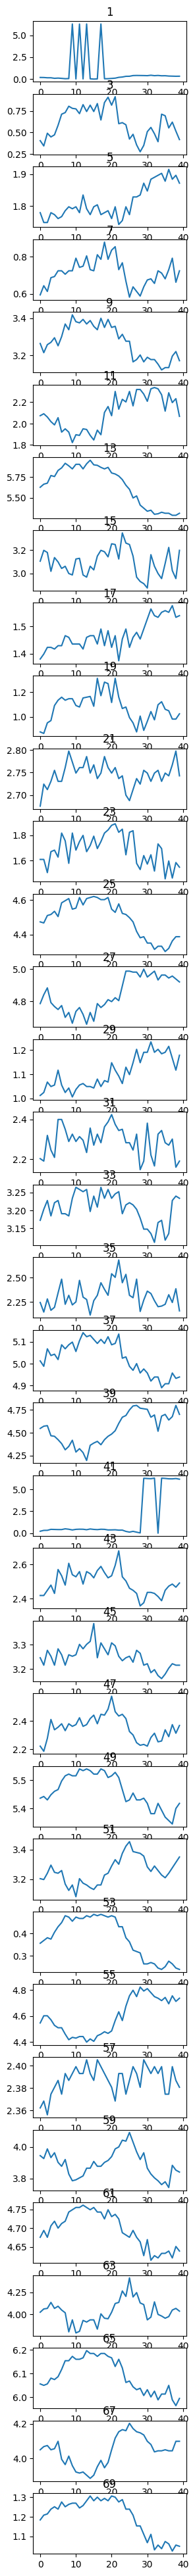

In [4]:
# plt.rcParams[' ']使用rc配置文件来自定义图形的各种默认属性
# plt.rcParams[’figure.figsize’] 图像显示大小
# plt.rcParams[’figure.dpi’] 图像分辨率
# plt.rcParams[’savefig.dpi’] 图片像素
plt.rcParams['figure.figsize'] =(3.0,50.0)
for i in range(1,X_data[0].shape[1],2):# 步长2,展示 phase 数据
    plt.subplot(35,1,int(i/2+1))# plt.subplot(a,b,i),a行数b列数，i位置索引,从1开始
    plt.plot(X_data[0,:,i])# 
    plt.title(str(i))
plt.show()

## 数据划分：测试集和训练集

In [5]:
labels

array([ 0,  0,  0, ..., 99, 99, 99])

In [6]:
'''
train_test_split方法能够将数据集按照用户的需要指定划分为训练集和测试集
train_data：所要划分的样本特征集
train_target：所要划分的样本结果
test_size：样本占比，如果是整数的话就是样本的数量
random_state：是随机数的种子
随机数的产生取决于种子，随机数和种子之间的关系遵从以下两个规则：
种子不同，产生不同的随机数；种子相同，即使实例不同也产生相同的随机数。

X_data有10000条数据，对应labels=[0,0,0...99,99,99]共10000个标签，
且分为了0-99 100个类，每个类100条数据，现在把X_data和对应的labels随机分为各5000条，作为训练集和测试集
'''
X_train,X_test,y_train,y_test = train_test_split(X_data, labels, test_size=0.5, random_state=666)
print(X_train.shape)
print(y_train.shape)

(5000, 40, 70)
(5000,)


## 2.添加噪音
> 解决不同环境下环境噪音（多径反射）问题

In [7]:
# 向数据中添加均值为mu，方差为sigma的高斯噪音
def add_noise(X_data, phase_sigma=0.02, RSSI_sigma=0.2, mu=0.0):
    noise=np.zeros(X_data.shape)# 先初始化noise，形状为X_data的全0矩阵
    size=noise[:,:,0].shape
    for i in range(X_data.shape[2]):
        if  i%2 == 0:
            noise[:,:,i]=np.random.normal(mu,RSSI_sigma,size)# np.random.normal：生成高斯分布的概率密度随机数
        else:
            noise[:,:,i]=np.random.normal(mu,phase_sigma,size)

    return noise+X_data

In [8]:
X_train_noise = add_noise(X_train)  # 生成一个添加了噪音的训练数据集，大小与原来的训练集相同
X_test_noise = add_noise(X_test)  # 生成一个添加了噪音的测试数据集，大小与原来的训练集相同
print(X_train_noise.shape)
print(X_test_noise.shape)

(5000, 40, 70)
(5000, 40, 70)


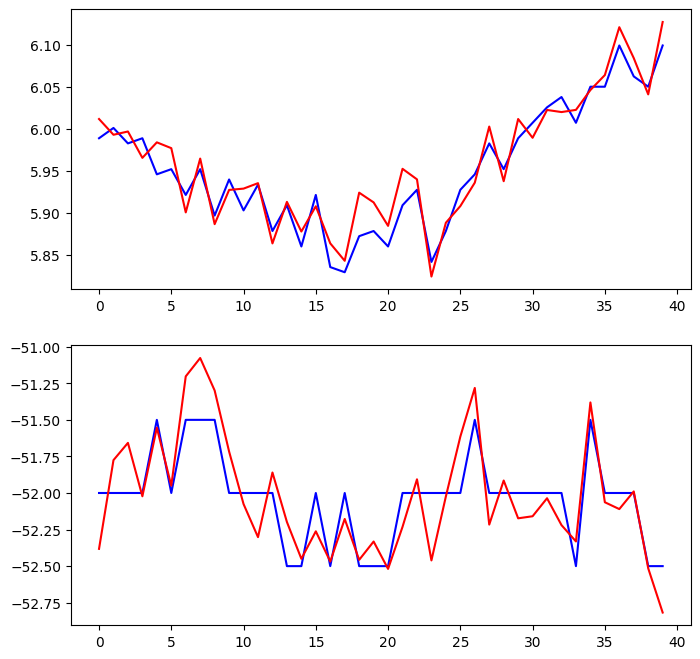

In [9]:
#测试效果
plt.rcParams['figure.figsize'] =(8.0,8.0)
# plt.subplot(a,b,i),a行数b列数，i位置索引,从1开始
# phase
plt.subplot(2,1,1)
plt.plot(X_train[2,:,1],'b')
plt.plot(X_train_noise[2,:,1],'r')# 加了噪声
# 振幅
plt.subplot(2,1,2)
plt.plot(X_train[2,:,0],'b')
plt.plot(X_train_noise[2,:,0],'r') #加了噪声
plt.show()

## 3.整体均匀改变数据大小
> 解决由于同一个人由于与标签的距离不同，而造成数据大小的整体改变

> 超参数：这里增大的百分比γ的取值范围为（-20%-+20%）

In [10]:
# 每个数据都放大或缩小（-20%，20%）
def scaling(X_data, uplimit=0.2, downlimit=-0.2):
    scale_data=[]
    for data in X_data:
        scale=(np.random.random()*(uplimit-downlimit)+downlimit)+1# np.random.random():生成0-1随机浮点数
        scale_data.append(scale*data)
        
    return np.array(scale_data)

In [11]:
X_train_noise_scale=scaling(X_train_noise)  #生成一个添加了噪音、大小改变的训练数据集，大小与原来的训练集相同
X_test_noise_scale=scaling(X_test_noise)  #生成一个添加了合成的数据、噪音的、大小改变的测试数据集，大小与原来的训练集相同
print(X_train_noise_scale.shape)
print(X_test_noise_scale.shape)

(5000, 40, 70)
(5000, 40, 70)


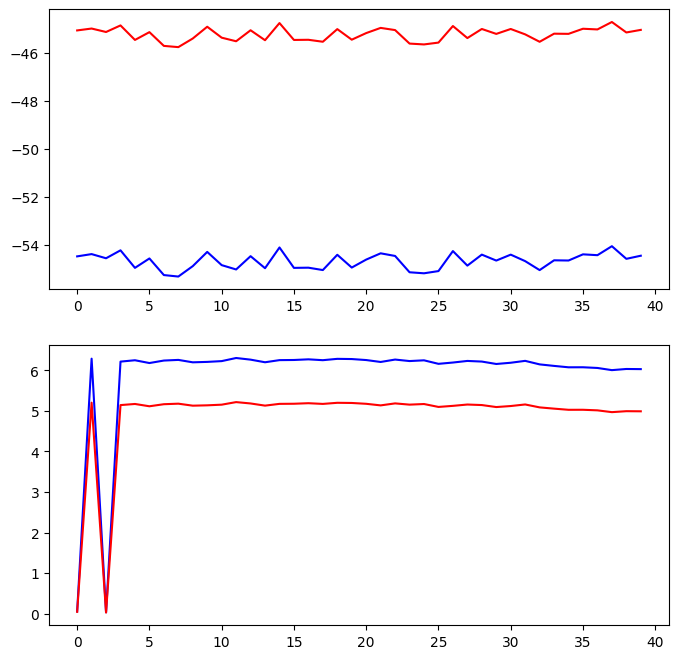

In [12]:
#测试效果
plt.rcParams['figure.figsize'] =(8.0,8.0)
j=20
plt.subplot(2,1,1)
i=0
plt.plot(X_train_noise[j,:,i],'b')
plt.plot(X_train_noise_scale[j,:,i],'r')

plt.subplot(2,1,2)
i=1
plt.plot(X_train_noise[j,:,i],'b')
plt.plot(X_train_noise_scale[j,:,i],'r')

plt.show()

## 4.数据拉伸/压缩
> 解决晃头时速度不同的问题，这代表着数据采集是采集一段固定时间内的晃头数据，而不是之前的将动作做一遍的数据

变形之后还有一个对齐的问题

>注意：这里有个问题是否对所有的增强的数据都要拉伸形变,还是随机取部分
对所有数据都进行（-30% - +30%）的随机形变

In [13]:
# 这里有个问题是否对所有增强的数据都要拉伸形变
# 这里的压缩选取（-30% - +30%）的随机形变
# 对时间序列重新取样，使其达到目标大小(1,40,70)->(1,size,70)，size是40的（-30% - +30%）的随机形变
# 形变后还要进行数据对齐，对齐的方案按之前的解决
def deformation_series(X_data,uplimit=0.3,downlimit=-0.3):
    deformation_data=[]
    for series in X_data:
        # 对 40 放大或缩小30%
        size=int((np.random.random()*(uplimit-downlimit)+downlimit)*X_data.shape[1])+X_data.shape[1]
        # np.newaxis：放在哪个位置，就会给哪个位置增加维度
        series=series[np.newaxis,:,:]# shape:(40,70)->(1,40,70)
        
        # 时间序列重新取样:对时间序列重新取样，使其达到目标大小(1,40,70)->(1,size,70)
        stretch_series=TimeSeriesResampler(sz=size).fit_transform(series)  #重采样，拉伸/压缩
        stretch_series=stretch_series[0]# (1,size,70)->(size,70)
        
        # 对齐
        if size > X_data.shape[1]:# 多出部分直接丢弃
            stretch_series=stretch_series[:X_data.shape[1]]
        elif size < X_data.shape[1]:# 不够部分用前面部分补充，形成循环
            stretch_series=np.vstack((stretch_series,stretch_series[:(X_data.shape[1]-size),:]))
        
        deformation_data.append(stretch_series)
    
    return np.array(deformation_data)     

In [14]:
X_train_noise_scale_deformation=deformation_series(X_train_noise_scale)
X_test_noise_scale_deformation=deformation_series(X_test_noise_scale)
print(X_train_noise_scale_deformation.shape)
print(X_test_noise_scale_deformation.shape)

(5000, 40, 70)
(5000, 40, 70)


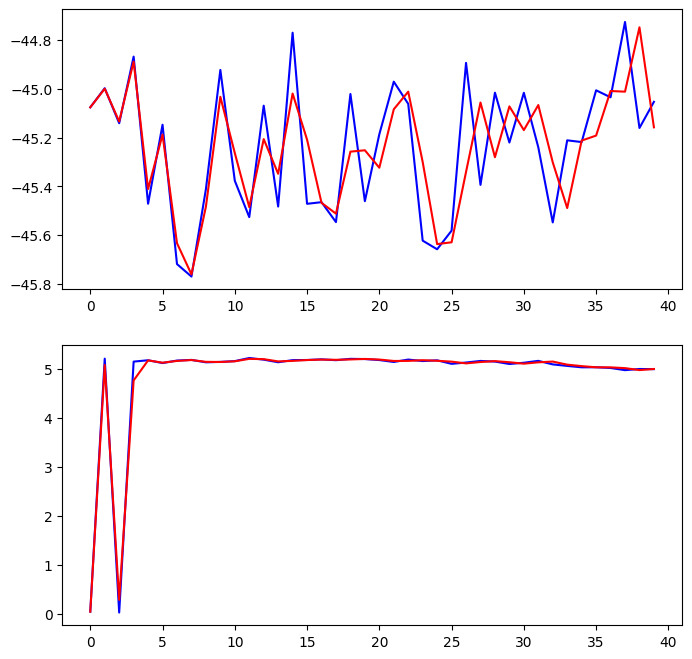

In [15]:
#测试效果
plt.rcParams['figure.figsize'] =(8.0,8.0)
j=20
plt.subplot(2,1,1)
i=0
plt.plot(X_train_noise_scale[j,:,i],'b')
plt.plot(X_train_noise_scale_deformation[j,:,i],'r')

plt.subplot(2,1,2)
i=1
plt.plot(X_train_noise_scale[j,:,i],'b')
plt.plot(X_train_noise_scale_deformation[j,:,i],'r')

plt.show()

## 5.翻转数据
> 解决一个人由于左右晃头的方向不同，而造成的差异

> 超参数η：对多少（百分比）的数据进行翻转这里先设定为选定15%

In [16]:
def reversal_data(X_data,percentage=0.15):
    size_=int(len(X_data)*percentage)   # 获得需要翻转的数据量
    '''
        np.random.choice(a, size, replace, p) 其作用是按要求生成一个一维数组
        a 是生成一维数组的来源，可以是int类型，可以是数组，也可以是list
        size 为从a中抽取的个数，即生成数组的维度
        replace 表示从a中是否不重复抽取，默认可重复
        p 与数组a相对应，表示取数组a中每个元素的概率，默认为选取每个元素的概率相同
    
        这里a是len(X_data),因此返回的是index,即0-9999随机的index

    '''
    index=np.random.choice(a=len(X_data),size=size_,replace=False) # 不重复抽样,随机抽取size个数据的索引
    # print(index)
    copy_data=X_data.copy()   # 创建副本,防止对原数据的改变
    # 对选定的索引样本进行翻转
    copy_data[index]=copy_data[index,::-1,:]# "::-1"：将数据倒序输出
    return copy_data

In [17]:
X_train_noise_scale_deformation_rev=reversal_data(X_train_noise_scale_deformation)
X_test_noise_scale_deformation_rev=reversal_data(X_test_noise_scale_deformation)
print(X_train_noise_scale_deformation_rev.shape)
print(X_test_noise_scale_deformation_rev.shape)

(5000, 40, 70)
(5000, 40, 70)


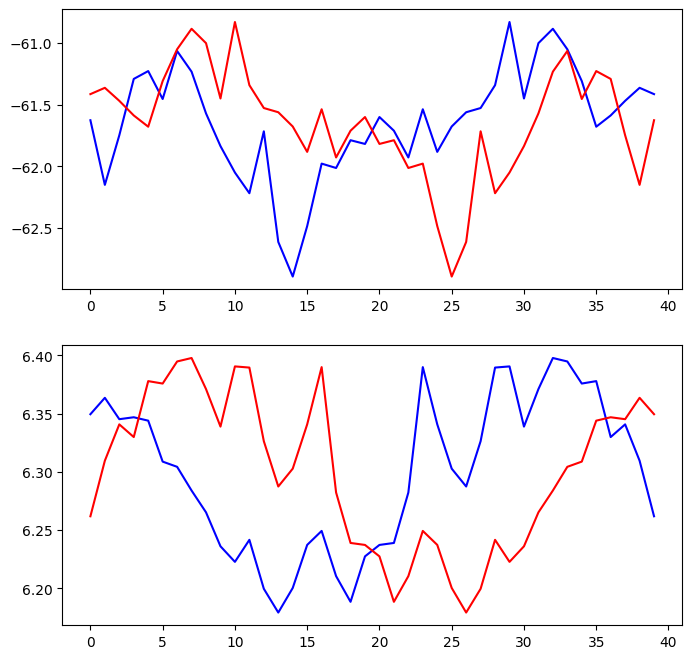

In [24]:
#测试效果
plt.rcParams['figure.figsize'] =(8.0,8.0)
j=9
plt.subplot(2,1,1)
i=0
plt.plot(X_train_noise_scale_deformation[j,:,i],'b')
plt.plot(X_train_noise_scale_deformation_rev[j,:,i],'r')

plt.subplot(2,1,2)
i=1
plt.plot(X_train_noise_scale_deformation[j,:,i],'b')
plt.plot(X_train_noise_scale_deformation_rev[j,:,i],'r')

plt.show()

In [ ]:
# #将数据以字典的形式压缩至original_data.npz文件中
# np.savez("../data/augment_base_data.npz",X_train_augment=X_train_augment, y_train_augment=y_train_augment,
#                                     X_test_augment=X_test_augment, y_test_augment=y_test_augment 
# )